In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import  torch, os
from    torch import nn
from    torch import optim
import  numpy as np
import data_handler
from trainer.trainer_factory import GenericTrainer
import networks
from copy import deepcopy

# Setting random seeds
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)

# Setting training configuration
args = {}
args['dataset'] = 'sine'
args['inner_lr'] = 0.001
args['meta_lr'] = 0.001
args['n_way'] = 1 # number of classes or outputs. In sinewave case, n_way is 1
args['k_spt'] = 10 # number of training samples
args['k_qry'] = 10 # number of test samples
args['device'] = torch.device('cpu')
args['tasknum'] = 50
args['epochs'] = 5000
# We don't use args['inner_steps']
args['inner_steps'] = 1 # number of steps in inner loop. We only consider this as 1

# Dataset (Sine-wave)

In [3]:
dataloader = data_handler.get_dataset(args)

# Model

In [4]:
# Initialize network
myModel = networks.ModelFactory.get_model('maml', args['n_way']).to(args['device'])

c:\Users\AI_15\momo\python_prj\2022_AI_Expert\CL\Day2\Day2\networks\optimization_based.py:24: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if name is 'linear':
c:\Users\AI_15\momo\python_prj\2022_AI_Expert\CL\Day2\Day2\networks\optimization_based.py:43: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if name is 'linear':
c:\Users\AI_15\momo\python_prj\2022_AI_Expert\CL\Day2\Day2\networks\optimization_based.py:70: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if name is 'linear':
c:\Users\AI_15\momo\python_prj\2022_AI_Expert\CL\Day2\Day2\networks\optimization_based.py:75: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif name is 'relu':


# MAML

In [5]:
class MAML_Trainer(GenericTrainer):
    """
    Meta Learner
    """
    def __init__(self, model, args):
        """
        :param args:
        """
        super(MAML_Trainer, self).__init__(model, args)

        self.meta_optim = optim.Adam(self.net.parameters(), lr=args['meta_lr'])
        self.loss = nn.MSELoss()
    
    def inner_loop(self, x_spt, y_spt, model, alpha):
        # the inner_step is 1. Therefore, you don't have to use for loops for the inner-loop
        
        ##########################################################################################
        
        # Write your code here
        
        logit = model(x_spt)
        loss = self.loss(logit, y_spt)
        # Compute gradient
        grad = torch.autograd.grad(loss, model.parameters(), create_graph=True, retain_graph=True)
        # Gradient descent on 0
        # simple way
        fast_weights = list(map(lambda p: p[1] - alpha * p[0], zip(grad, model.parameters())))
        return fast_weights
        # 2nd way
        '''
        fast_weights = []
        for grad, p in zip(grad, model.parameters()):
            fast_weights.append(p - alpha * grad)
        retrun fast_weights
        '''
        ##########################################################################################
        
    
    def Meta_Train(self, x_spt, y_spt, x_qry, y_qry, train=True):
        """
        :param x_spt:   [tasknum, setsz, 1]
         - Training input data
        :param y_spt:   [tasknum, setsz, 1]
         - Training target data
        :param x_qry:   [tasknum, querysz, 1]
         - Test input data
        :param y_qry:   [tasknum, querysz, 1]
         - Test target data
        :return: 'losses_q' (a list)
        """
        
        tasknum = x_qry.size(0)
        losses_q = [0 for _ in range(self.inner_step + 1)]
        
        # results for meta-training
        # Sine wave: MSE loss for all tasks
        # In a list 'losses_q', it should contain MSE loss computed using pre and post updated parameters
        # The components in 'losses_q' are as follows:
        # losses_q[0]: results for pre-update model
        # losses_q[1]: results for post-update model
        
        for i in range(tasknum):
            # 1. Compute loss using initial parameter
            
            logits_q = self.net(x_qry[i], vars=None)
            loss_q = self.loss(logits_q, y_qry[i])
            losses_q[0] += loss_q
            
            # Inner-loop
            fast_weights = self.inner_loop(x_spt[i], y_spt[i], self.net, self.inner_lr)
            
            # 2. Compute loss using adapted parameter
            logits_q = self.net(x_qry[i], fast_weights)
            loss_q = self.loss(logits_q, y_qry[i])
            losses_q[1] += loss_q
        
        
        
        if train:
            # Outer-loop
            
            ##########################################################################################
        
            # Write your code here

            loss_q = losses_q[-1]
            self.meta_optim.zero_grad()
            loss_q.backward()
            self.meta_optim.step() #theta update

            ##########################################################################################
        
        losses_q = np.array([loss.item() for loss in losses_q])
        return losses_q / tasknum


# Train MAML

In [6]:
MAML = MAML_Trainer(myModel, args)
MAML.train(dataloader, args['epochs'])

step: 0 	training loss: [8.90975891 5.36615784]
Test loss: [8.44 4.76]
step: 50 	training loss: [4.33448486 4.22524933]
step: 100 	training loss: [3.18619446 3.16318848]
step: 150 	training loss: [4.01066681 3.85922943]
step: 200 	training loss: [4.05742462 3.66310883]
step: 250 	training loss: [3.92084473 3.83348846]
step: 300 	training loss: [3.755896   3.41664093]
step: 350 	training loss: [3.4031601  3.03974548]
step: 400 	training loss: [3.31888641 2.92276917]
step: 450 	training loss: [2.89392853 2.57187897]
step: 500 	training loss: [3.3452774  3.09833038]
Test loss: [3.238 2.912]
step: 550 	training loss: [3.46914581 3.02768616]
step: 600 	training loss: [3.80841064 3.39065399]
step: 650 	training loss: [2.97076691 2.554823  ]
step: 700 	training loss: [3.59206299 3.04393433]
step: 750 	training loss: [3.05342072 2.58625   ]
step: 800 	training loss: [3.0978006  2.23180832]
step: 850 	training loss: [3.46828552 2.53796814]
step: 900 	training loss: [3.35657867 2.35875504]
step:

# Evaluate the performance
## 1. Plot ground truth function & support set

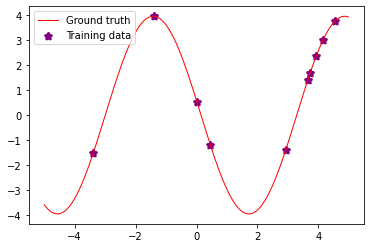

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

amplitude = np.random.uniform(0.1, 5)
phase = np.random.uniform(0, np.pi)

x = np.arange(1000) / 1000 * (10) - 5
y = np.sin(x + phase) * amplitude

x_qry = np.random.rand(10) * 10 - 5
y_qry = np.sin(x_qry + phase) * amplitude

plt.plot(x, y, color='red', linestyle='-', label='Ground truth', linewidth=1)
plt.scatter(x_qry, y_qry, color='purple', linestyle='-', label='Training data', linewidth=3, marker = '*')

plt.legend()

# Load pre-trained MAML model for visualization
### If you already finished training a model, you can skip this step

In [8]:
myModel_answer = networks.ModelFactory.get_model('maml', args['n_way']).to(args['device'])
myModel_answer_state_dict = torch.load('maml_sine_model.pt', map_location=torch.device(args['device']))

for key1, key2 in zip(myModel_answer.state_dict().keys(), myModel_answer_state_dict.keys()):
    
    if myModel_answer.state_dict()[key1].shape == torch.tensor(1).shape:
        myModel_answer.state_dict()[key1] = myModel_answer_state_dict[key2]
    else:
        myModel_answer.state_dict()[key1][:] = myModel_answer_state_dict[key2][:]

## 2. Plot pre-update function

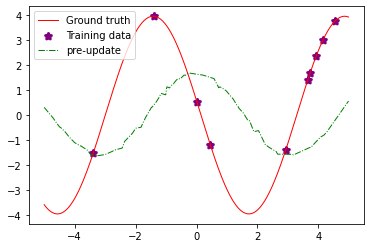

In [9]:
x_reshape = np.array(x).astype(np.float32).reshape(1, 1000, 1)
y_reshape = np.array(y).astype(np.float32).reshape(1, 1000, 1)

x_tensor = torch.from_numpy(x_reshape).to(args['device'])
y_tensor = torch.from_numpy(y_reshape).to(args['device'])

# Before adaptation

# Answer
model = myModel_answer

# A model that you trained
# model = myModel

y_pred = model(x_tensor).squeeze()

plt.plot(x, y, color='red', linestyle='-', label='Ground truth', linewidth=1)
plt.scatter(x_qry, y_qry, color='purple', linestyle='-', label='Training data', linewidth=3, marker = '*')
plt.plot(x, y_pred.detach().numpy(), color='green', linestyle='-.', label='pre-update', linewidth=1)

plt.legend()

# 3. Plot post-update function

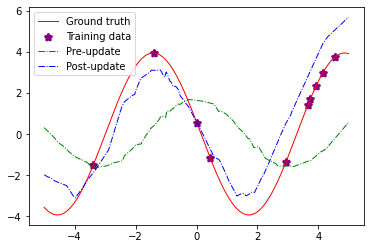

In [10]:
x_qry_reshape = np.array(x_qry).astype(np.float32).reshape(1, 10, 1)
y_qry_reshape = np.array(y_qry).astype(np.float32).reshape(1, 10, 1)

x_qry_tensor = torch.from_numpy(x_qry_reshape).to(args['device'])
y_qry_tensor = torch.from_numpy(y_qry_reshape).to(args['device'])

# Fast adaptation

# Answer
model = myModel_answer

# A model that you trained
# model = myModel

fast_weights = MAML.inner_loop(x_qry_tensor, y_qry_tensor, model, args['inner_lr'])
y_pred_after = model(x_tensor, fast_weights).squeeze()

plt.plot(x, y, color='red', linestyle='-', label='Ground truth', linewidth=1)
plt.scatter(x_qry, y_qry, color='purple', linestyle='-', label='Training data', linewidth=3, marker = '*')
plt.plot(x, y_pred.detach().numpy(), color='green', linestyle='-.', label='Pre-update', linewidth=1)
plt.plot(x, y_pred_after.detach().numpy(), color='blue', linestyle='-.', label='Post-update', linewidth=1)

plt.legend()